# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem defition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:

# Import trainnig and validation data
data = pd.read_csv("../data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
data.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [5]:
data.saledate

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

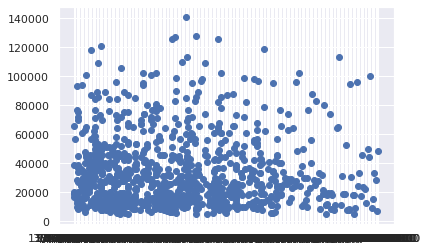

In [6]:
fig, ax = plt.subplots()
ax.scatter(data["saledate"][:1000], data["SalePrice"][:1000])

<AxesSubplot:ylabel='Frequency'>

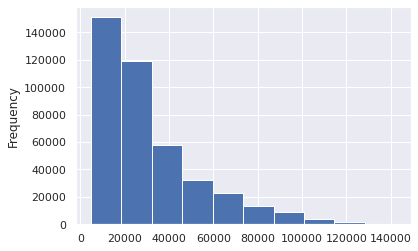

In [7]:
data.SalePrice.plot(kind="hist")

### Parsing dates

When we work with time series data, we want to enrich the time & date components as much as posible 

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter

In [8]:
# Import data again but this time parse dates
data = pd.read_csv("../data/bluebook-for-bulldozers/TrainAndValid.csv", parse_dates=["saledate"], low_memory=False)

In [9]:
data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data.saledate.dtype

dtype('<M8[ns]')

In [11]:
data.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

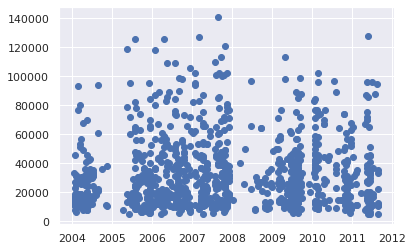

In [12]:
fig, ax = plt.subplots()
ax.scatter(data.saledate[:1000], data.SalePrice[:1000])

## Sort DataFrame by saledate

when working with time series data, it's good idea to sort by date

In [13]:
# Sort DataFrame By saledate
data.sort_values(by="saledate",ascending=True, inplace=True)
data.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

## Make copy original DataFrame

We make a copy of the original dateframe so when manipulate the copy, we have still got our original data.

In [14]:
df_tmp = data.copy()

In [15]:
df_tmp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add datetime parameters for `saledate` column


In [16]:
df_tmp["saleYear"] = df_tmp["saledate"].dt.year
df_tmp["saleMonth"] = df_tmp["saledate"].dt.month
df_tmp["saleDay"] = df_tmp["saledate"].dt.day
df_tmp["saleDayOfWeek"] = df_tmp["saledate"].dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp["saledate"].dt.dayofyear

In [17]:
df_tmp.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls', 'saleYear',
       'saleMonth', 'saleDay', 'saleDayOfWeek', 'saleDayOfYear'],

In [18]:
cols = ['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saleYear', 'saleMonth', 'saleDay', 'saleDayOfWeek', 'saleDayOfYear',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls']
df_tmp = df_tmp[cols]

In [19]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saleYear,1989,1989,1989,1989,1989


In [20]:
# Now we've enriched our DataFrame with date time features, we can remove saledate out of our dataframe
df_tmp.drop("saledate",axis=1, inplace=True)

/home/mvt/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
df_tmp.columns.values

array(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter',
       'UsageBand', 'saleYear', 'saleMonth', 'saleDay', 'saleDayOfWeek',
       'saleDayOfYear', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting',
       'Blade_Type', 'Travel_Controls', 'Differential_Type',
       'Steering_Controls'], dtyp

In [22]:
# Check values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [23]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saleYear                  412698 non-null  int64  
 10  saleMonth                 412698 non-null  int64  
 11  saleDay                   412698 non-null  int64  
 12  saleDayOfWeek             412698 non-null  int64  
 13  saleDayOfYear             412698 non-nu

## Convert string to categories

One way we can turn all of our data into numbers is by converting them into pandas categories

We can check the different datatypes compatible with pandas here:
https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html

In [24]:
# Check UsageBand type
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [25]:
df_tmp.values

array([[1646770, 9500.0, 1126363, ..., 'None or Unspecified', nan, nan],
       [1821514, 14000.0, 1194089, ..., nan, 'Standard', 'Conventional'],
       [1505138, 50000.0, 1473654, ..., 'None or Unspecified', nan, nan],
       ...,
       [6313029, 16000.0, 1918416, ..., nan, nan, nan],
       [6266251, 55000.0, 509560, ..., nan, nan, nan],
       [6283635, 34000.0, 1869284, ..., nan, 'Standard', 'Conventional']],
      dtype=object)

In [26]:
# Find the columns which contains string
for label, content in df_tmp.items() :        
    if pd.api.types.is_string_dtype(content) : 
        print(label)        

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [27]:
# This will turn all of the string values into actegory value
for label, content in df_tmp.items() : 
    if pd.api.types.is_string_dtype(content) : 
        df_tmp[label] = content.astype("category").cat.as_ordered()

/home/mvt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   saleYear                  412698 non-null  int64   
 10  saleMonth                 412698 non-null  int64   
 11  saleDay                   412698 non-null  int64   
 12  saleDayOfWeek             412698 non-null  int64   
 13  saleDayOfYear           

In [29]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [30]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas Categories we now have a way to access all of our data in the form of numbers.

But we still have a bunch of missing value...

In [31]:
# Check missing values ratio
df_tmp.isnull().sum() / len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
saleYear                    0.000000
saleMonth                   0.000000
saleDay                     0.000000
saleDayOfWeek               0.000000
saleDayOfYear               0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
P

## Save preprocessed data

In [32]:
# Export current tmp dataframe
df_tmp.to_csv("../data/bluebook-for-bulldozers/train_tmp.csv", index=False)

In [33]:
# import preprocessed dataframe
df_tmp = pd.read_csv("../data/bluebook-for-bulldozers/train_tmp.csv", low_memory=False)

In [34]:
df_tmp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saleYear,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
412694,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412695,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412696,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df_tmp.isnull().sum() 

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saleYear                         0
saleMonth                        0
saleDay                          0
saleDayOfWeek                    0
saleDayOfYear                    0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control        

## Filling missing values

### Filling missing numerical values first


In [36]:
# Show Columns contain numerical values
for label, content in df_tmp.items() : 
    if pd.api.types.is_numeric_dtype(content) : 
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [37]:
# Check for which numeric columns have null values
for label, content in df_tmp.items() : 
    if pd.api.types.is_numeric_dtype(content) : 
        if pd.isnull(content).sum() :
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [38]:
# Fill numeric rows with the median
for label, content in df_tmp.items() : 
    if pd.api.types.is_numeric_dtype(content) : 
        if pd.isnull(content).sum() : 
            # Add a binary column which tells us if the data was missing
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [39]:
# Demonstrate how median is more robust than mean
hundreds = np.full((1000,),100)
hundreds_billion = np.append(hundreds, 1000000000)

np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0)

In [41]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [42]:
df_tmp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saleYear,...,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,NaN,1989,...,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,False,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,NaN,1989,...,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,False,True
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,NaN,1989,...,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,False,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,NaN,1989,...,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,False,True
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,NaN,1989,...,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6302984,16000.0,1915521,5266,149,99.0,2001,0.0,NaN,2012,...,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN,False,True
412694,6324811,6000.0,1919104,19330,149,99.0,2004,0.0,NaN,2012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
412695,6313029,16000.0,1918416,17244,149,99.0,2004,0.0,NaN,2012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
412696,6266251,55000.0,509560,3357,149,99.0,1993,0.0,NaN,2012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True


## Filling and tuning categorical variables into numbers

In [43]:
# Check the columns which aren't numerical
for label, content in df_tmp.items() : 
    if not pd.api.types.is_numeric_dtype(content) : 
        # Add binary column to indicate whether sample had missing value or not
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into number+ 1
        df_tmp[label] = pd.Categorical(content).codes + 1 

In [44]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [45]:
df_tmp.isnull().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [46]:
len(df_tmp)

412698

In [47]:
%%time
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
model = RandomForestRegressor(n_jobs=-1, random_state=42,max_samples=10000)

# Fit and model
model.fit(df_tmp.drop("SalePrice",axis=1),df_tmp["SalePrice"])

CPU times: user 50.8 s, sys: 525 ms, total: 51.3 s
Wall time: 16.8 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [48]:
model.score(df_tmp.drop("SalePrice",axis=1),df_tmp["SalePrice"])

0.8604146495744976

**Question;** Why doesn't the above metric hold water? (why isn't the metric reliable)

### Splitting data into train/validation sets


In [49]:
df_tmp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [50]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [51]:
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val) , len(df_train)

(11573, 401125)

In [52]:
# Split data into X & y 
x_train,y_train, x_valid , y_valid = df_train.drop("SalePrice", axis=1), df_train["SalePrice"] , df_val.drop("SalePrice",axis=1), df_val["SalePrice"]
x_train.shape , x_valid.shape, y_train.shape, y_valid.shape

((401125, 102), (11573, 102), (401125,), (11573,))

## Building an evaluation function

In [53]:
# Create evaluation function (the competition uses RMLSE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error,r2_score

def rmlse(y_test,y_preds) : 
    """
    Calculate root mean squared log error between predictions and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few deffirent levels
def show_scores(model) : 
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_valid)
    scores = {
        "Train MAE" : mean_absolute_error(y_train, train_preds),
        "Valid MAE" : mean_absolute_error(y_valid, val_preds),
        "Train RMLSE" : rmlse(y_train, train_preds),
        "Valid RMLSE" : rmlse(y_valid, val_preds),
        "Train R^2" : r2_score(y_train, train_preds),
        "Valid R^2" : r2_score(y_valid, val_preds)
    }
    return scores


## Testing out model on a subset( to tune the hyperparameter)

In [54]:
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)

model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)>

In [55]:
%%time 
model.fit(x_train,y_train)

CPU times: user 49.7 s, sys: 472 ms, total: 50.2 s
Wall time: 15.3 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [56]:
%%time
show_scores(model)

CPU times: user 15.7 s, sys: 318 ms, total: 16 s
Wall time: 6.28 s


{'Train MAE': 5561.621095294484,
 'Valid MAE': 7177.937895100665,
 'Train RMLSE': 0.25765752330801545,
 'Valid RMLSE': 0.2937381542354158,
 'Train R^2': 0.8606420252458414,
 'Valid R^2': 0.8316899187547838}

### Hyperparameter with RandomizedSearchCV

In [59]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {
    "n_estimators" : np.arange(10,200,10) ,
    "max_depth" : [None,10,20],
    "min_samples_split" : np.arange(2,20,2),
    "min_samples_leaf" : np.arange(1,20,2),
    "max_features" : [0.5,1,"sqrt", "auto"],
    "max_samples" : [10000]
}

# Instantiate model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,random_state=42),
                              rf_grid,
                              n_iter=2,
                              cv=2,
                              verbose=True
                             )
rs_model.fit(x_train,y_train)


Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min finished


CPU times: user 1min 26s, sys: 2.04 s, total: 1min 28s
Wall time: 1min 30s


RandomizedSearchCV(cv=2,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   verbose=True)

In [60]:
rs_model.best_params_

{'n_estimators': 170,
 'min_samples_split': 16,
 'min_samples_leaf': 15,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [61]:
show_scores(rs_model)

{'Train MAE': 6349.925660625919,
 'Valid MAE': 7920.451291033137,
 'Train RMLSE': 0.2863864240795864,
 'Valid RMLSE': 0.3154150587465013,
 'Train R^2': 0.8178983748193972,
 'Valid R^2': 0.7875357906688284}

## Train model with the best hyperparameter

In [62]:
%%time 

#Most ideal hyperparameter
ideal_model = RandomForestRegressor(n_estimators=40, 
                                    min_samples_leaf=1,
                                    min_impurity_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42
                                   )

# Fit ideal model
ideal_model.fit(x_train, y_train)


/home/mvt/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/mvt/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/mvt/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/mvt/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity

/home/mvt/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/mvt/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/mvt/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/mvt/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity

CPU times: user 5min 16s, sys: 1.39 s, total: 5min 18s
Wall time: 1min 23s


RandomForestRegressor(max_features=0.5, min_impurity_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [63]:
show_scores(ideal_model)

{'Train MAE': 1609.2256444208988,
 'Valid MAE': 5985.825478844438,
 'Train RMLSE': 0.0860397358089718,
 'Valid RMLSE': 0.24917319042636976,
 'Train R^2': 0.9869757469396042,
 'Valid R^2': 0.8802997395898468}

## Make prediction on test data

In [64]:
df_test = pd.read_csv("../data/bluebook-for-bulldozers/Test.csv", parse_dates=["saledate"], low_memory=False)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [65]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

In [66]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [67]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

### Preprocessing data


In [68]:
df_test_tmp = df_test.copy()
def preprocessing_data(df) : 
    """
    Perform transformation on df and returns transformed df
    """
    # Add datetime parameter on saledate column
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    # drop saledate
    df.drop("saledate", axis=1, inplace=True)
    # Fill the numeric row with median
    for label, content in df.items() : 
        if pd.api.types.is_numeric_dtype(content) : 
            if pd.isnull(content).sum() : 
                # Add a binary column which tell us whether data had missing value or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
            
    # Full the categorical missing data and turn categories into numbers 
    for label, content in df.items() :
        if not pd.api.types.is_numeric_dtype(content) : 
            df[label+"_is_missing"] = pd.isnull(content) 
            df[label] = pd.Categorical(content).codes + 1 
    return df
preprocessing_data(df_test_tmp)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True


In [69]:
df_test_tmp.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
...,...,...,...,...,...
Backhoe_Mounting_is_missing,True,True,True,True,False
Blade_Type_is_missing,True,True,True,True,False
Travel_Controls_is_missing,True,True,True,True,False
Differential_Type_is_missing,True,False,True,True,True


In [70]:
df_test_tmp.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
...,...,...,...,...,...
Backhoe_Mounting_is_missing,True,True,True,True,False
Blade_Type_is_missing,True,True,True,True,False
Travel_Controls_is_missing,True,True,True,True,False
Differential_Type_is_missing,True,False,True,True,True


In [71]:
# We can find how the columns differ using sets
set(x_train.columns) - set(df_test_tmp.columns)

{'auctioneerID_is_missing'}

In [72]:
set(df_test_tmp.columns) - set(x_train.columns) 

set()

In [73]:
df_test_tmp["auctioneerID_is_missing_data"] = False

In [74]:
x_train.shape, df_test_tmp.shape

((401125, 102), (12457, 102))

In [82]:
# Make predictions on updated test data
test_pred = ideal_model.predict(df_test_tmp)
test_pred

array([53812.5 , 28840.  , 40163.75, ..., 24068.75, 40716.25, 37378.75])

 We've made some predictions but they're not in the same format Kaggle is asking for:
 
https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [89]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_pred
df_preds

,SalesID,SalePrice
0,1227829,53812.50
1,1227844,28840.00
2,1227847,40163.75
3,1227848,42228.75
4,1227863,39310.00
...,...,...
12452,6643171,36416.25
12453,6643173,40941.25
12454,6643184,24068.75
12455,6643186,40716.25


In [91]:
# Export prediction data
df_preds.to_csv("../data/bluebook-for-bulldozers/test_predictions.csv", index=False)

## Features impotance

In [93]:
# Find features importance in our best model
ideal_model.feature_importances_

array([3.68883835e-02, 2.43238478e-02, 4.72854998e-02, 2.09051490e-03,
       4.87064301e-03, 2.04308633e-01, 3.97264326e-03, 1.57240504e-03,
       7.32592406e-02, 6.03114782e-03, 9.44110134e-03, 5.00179490e-03,
       1.33934571e-02, 4.07176607e-02, 4.91833431e-02, 5.55253733e-02,
       4.79802335e-03, 1.28490338e-02, 1.46110946e-01, 4.30780287e-02,
       9.08973045e-03, 1.65955309e-03, 2.06150238e-03, 2.93958476e-03,
       5.09770630e-02, 9.49698907e-04, 2.56009732e-04, 8.43347343e-04,
       1.97304822e-04, 1.32301447e-03, 9.66446938e-05, 2.35028606e-03,
       8.70535794e-03, 9.43476835e-04, 1.52484512e-04, 2.39432214e-03,
       2.30869273e-03, 3.51254582e-03, 3.13285018e-03, 3.51691698e-04,
       7.40738190e-03, 1.04379471e-03, 1.64385584e-02, 2.39352938e-03,
       2.50339545e-03, 7.13019165e-04, 1.10035612e-03, 2.03282524e-03,
       8.12144737e-04, 4.09028928e-04, 5.52397131e-04, 4.88000420e-04,
       2.10371761e-03, 1.01694019e-03, 2.84094992e-04, 2.11002692e-04,
      

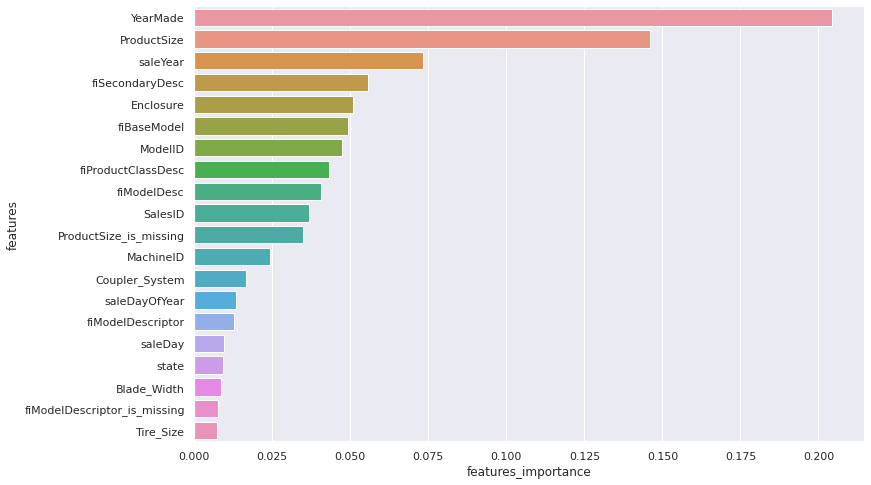

In [122]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20) : 
    df = (pd.DataFrame({"features" : columns,
                        "features_importance": importances})
    .sort_values("features_importance", ascending=False)
    .reset_index(drop=True))   
    # plot df
    fig,ax = plt.subplots(figsize=(12,8))
#     ax.barh(df.loc[:n,"features"], df.loc[:n,"features_importance"])
#     ax.set_ylabel("Features")
#     ax.set_xlabel("Features importance")
#     ax.invert_yaxis()
    sns.barplot(x="features_importance",
                    y="features",
                    data=df[:n],
                    orient="h")
plot_features(x_train.columns, ideal_model.feature_importances_)

In [113]:
data["ProductSize"].value_counts()

Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: ProductSize, dtype: int64

In [115]:
data["Enclosure"].value_counts()

OROPS                  177971
EROPS                  141769
EROPS w AC              92601
EROPS AC                   18
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64

**Question to finish:** Why might knowing the feature importances of a trained machine learning model be helpful?

**Final challenge/extension:** What other machine learning models could you try on our dataset? 
**Hint:** https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html check out the regression section of this map, or try to look at something like CatBoost.ai or XGBooost.ai.